# Introduction

The goal of this notebook is to provide a basic implementation of the a convolutional [autoencoder](https://en.wikipedia.org/wiki/Autoencoder). The goal of this network is to compute the identity function, _i.e._ reconstruct an image as close as possible to its input. This task is not trivial as in the network, the data has to go through a bottleneck. After the training, we can split the network in two parts: the encoder and the decoder. They respectively compress and uncompress the information.  

In [1]:
%matplotlib inline
import numpy             as np
import matplotlib.pyplot as plt
import keras.backend     as K

from keras.models       import Sequential
from keras.layers       import Dense
from keras.layers       import BatchNormalization
from keras.layers       import Reshape
from keras.layers       import UpSampling2D
from keras.layers       import Convolution2D
from keras.layers       import Activation
from keras.layers       import Flatten
from keras.layers       import AveragePooling2D
from keras.optimizers   import Adam
from keras.datasets     import mnist

from tqdm import tqdm

Using TensorFlow backend.


In [2]:
def limit_mem():
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))

We load the MNIST data and reshape it into the 2D arrays.

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
n       = len(X_train)
X_train = X_train.reshape(n          , -1).astype(np.float32)
X_test  = X_test.reshape( len(X_test), -1).astype(np.float32)
X       = np.concatenate([X_train, X_test])
X       = (X - 127.5) / 127.5
X       = np.reshape(X, (-1, 28, 28, 1))

We now choose the number of dimensions of the code.

In [4]:
encoding_size = 2

The encoder is a sequence of convolutional layers and average pooling with a fully connected layer to produce the final code.

In [5]:
encoder = Sequential([
    Convolution2D(64, (3, 3), padding = 'same', input_shape = (28, 28, 1)),
    BatchNormalization(axis = 1),
    Activation('relu'),
    Convolution2D(64, (3, 3), padding = 'same'),
    BatchNormalization(axis = 1),
    Activation('relu'),
    AveragePooling2D(),
    Convolution2D(128, (3, 3), padding = 'same'),
    BatchNormalization(axis = 1),
    Activation('relu'),
    Convolution2D(128, (3, 3), padding = 'same'),
    BatchNormalization(axis = 1),
    Activation('relu'),
    AveragePooling2D(),
    Flatten(),
    Dense(128),
    BatchNormalization(),
    Activation('relu'),
    Dense(encoding_size),
    Activation('tanh')
])

The decoder first applies a fully connected layer to reshape the input into a shape that 'divide' the final picture size (7, 7, 1). After that, a sequence of upsamplings and convolutions is applied to reach the correct size.

In [6]:
decoder = Sequential([
    Dense(49, input_shape = (encoding_size,)),
    BatchNormalization(),
    Activation('relu'),
    Reshape((7, 7, 1)),
    Convolution2D(128, (3, 3), padding = 'same'),
    BatchNormalization(axis = 1),
    Activation('relu'),
    Convolution2D(128, (3, 3), padding = 'same'),
    BatchNormalization(axis = 1),
    Activation('relu'),
    UpSampling2D(),
    Convolution2D(64, (3, 3), padding = 'same'),
    BatchNormalization(axis = 1),
    Activation('relu'),
    Convolution2D(64, (3, 3), padding = 'same'),
    BatchNormalization(axis = 1),
    Activation('relu'),
    UpSampling2D(),
    Convolution2D(1, (3, 3), padding = 'same', activation = 'tanh')
])

As explained earlier, the autoencoder is a concatenation of the encoder and the decoder.

In [7]:
autoencoder = Sequential([
    encoder,
    decoder
])
autoencoder.compile(optimizer = Adam(), loss = 'mse')

To test the architecture, we select a sample of the dataset to train the autoencoder.

In [8]:
X_sample = np.random.permutation(X)[:5000]

In [9]:
autoencoder.fit(X_sample, X_sample, batch_size = 128, epochs = 20)

Epoch 1/20
5000/5000 [==============================] - 17s - loss: 0.4812     

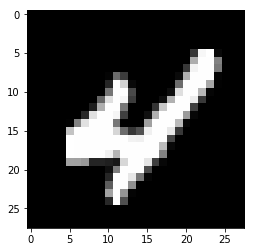

In [10]:
plt.imshow(X_sample[497].squeeze(), cmap = 'gray')

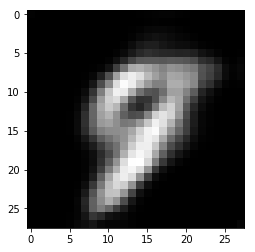

In [11]:
plt.imshow(autoencoder.predict(np.expand_dims(X_sample[497], 0)).squeeze(), cmap = 'gray')

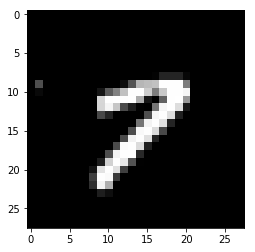

In [12]:
plt.imshow(X[29].squeeze(), cmap = 'gray')

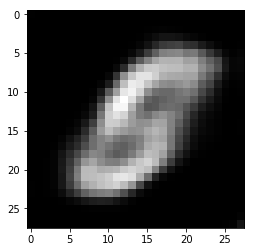

In [13]:
plt.imshow(autoencoder.predict(np.expand_dims(X[29], 0)).squeeze(), cmap = 'gray')

In [14]:
autoencoder.optimizer.lr = 1e-4

In [15]:
autoencoder.fit(X_sample, X_sample, batch_size = 64, epochs = 10)

Epoch 1/10
5000/5000 [==============================] - 16s - loss: 0.1978     

In [16]:
autoencoder.save_weights('../models/autoencoder_%dD.h5' % encoding_size)

In [17]:
autoencoder.load_weights('../models/autoencoder_%dD.h5' % encoding_size)

Now that we have a trained model, we are going to explore the space of latent encoding. As the last layer of the encoder is an hyperbolic tangent function, the valid values for codes are in the interval [-1, 1]<sup>2</sup>. We plot a 2D grid that correspond to various decoding in this space.

In [18]:
size = 20

In [19]:
def create_visualization(decoder, size):
    plt.figure(figsize = (15, 15))
    for i, x in enumerate(np.linspace(-1, 1, size)):
        for j, y in enumerate(np.linspace(-1, 1, size)):
            plt.subplot(size, size, i * size + j + 1)
            img = decoder.predict(np.array([[x, y]])).squeeze()
            plt.imshow(img, cmap = 'gray')
            plt.axis('off')

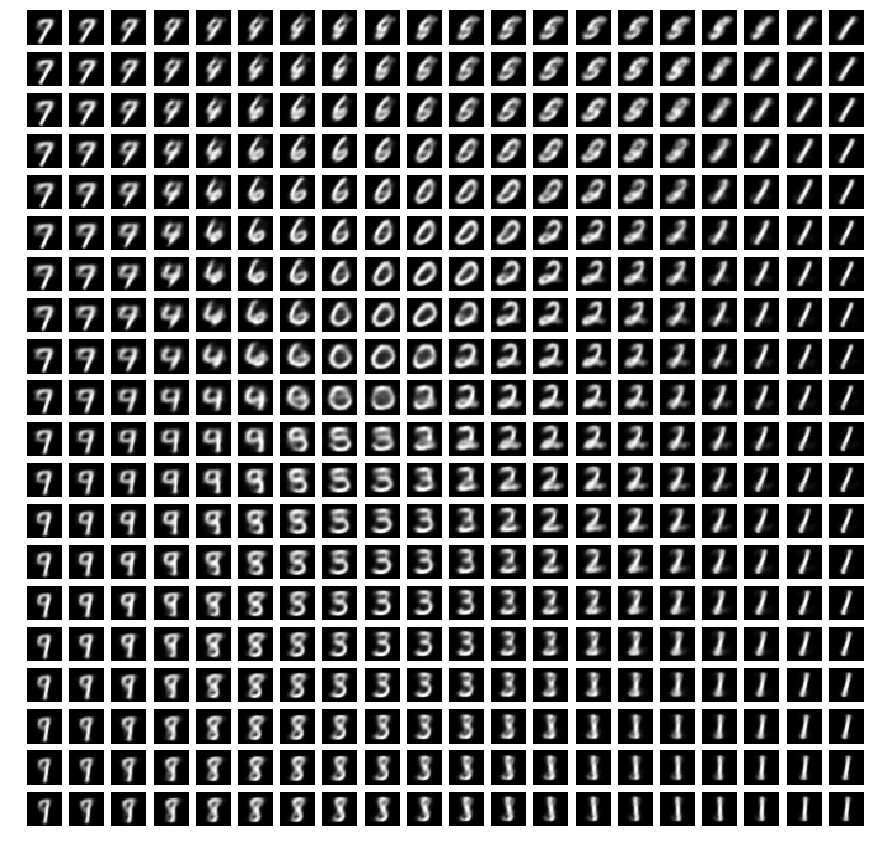

In [20]:
create_visualization(decoder, size)